In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data/T.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
9835,2022-11-28,19.100000,19.150000,18.770000,18.820000,18.820000,27780200
9836,2022-11-29,18.790001,19.030001,18.750000,19.010000,19.010000,24088000
9837,2022-11-30,18.940001,19.280001,18.799999,19.280001,19.280001,59282600
9838,2022-12-01,19.290001,19.400000,19.090000,19.190001,19.190001,31615500
9839,2022-12-02,19.049999,19.059999,18.860001,19.020000,19.020000,33475400


In [3]:
df.shape

(9840, 7)

In [4]:
df = df[['Date', 'Close']]

In [5]:
df['Date']

0       1983-11-21
1       1983-11-22
2       1983-11-23
3       1983-11-25
4       1983-11-28
           ...    
9835    2022-11-28
9836    2022-11-29
9837    2022-11-30
9838    2022-12-01
9839    2022-12-02
Name: Date, Length: 9840, dtype: object

In [6]:
# Converting object to Date-Time object.

import datetime

def to_date(s):
    spl = s.split('-')
    y, m, d = spl[0], spl[1], spl[2]
    return datetime.datetime(year=int(y), month = int(m), day = int(d))

In [7]:
df['Date'] = df['Date'].apply(to_date)

In [8]:
df['Date']

0      1983-11-21
1      1983-11-22
2      1983-11-23
3      1983-11-25
4      1983-11-28
          ...    
9835   2022-11-28
9836   2022-11-29
9837   2022-11-30
9838   2022-12-01
9839   2022-12-02
Name: Date, Length: 9840, dtype: datetime64[ns]

In [9]:
# making date the index column

df.index = df.pop('Date')

In [10]:
df.head()

,Close
Date,
1983-11-21,3.878713
1983-11-22,3.847243
1983-11-23,3.831508
1983-11-25,3.839376
1983-11-28,3.800038


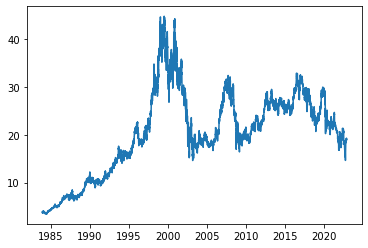

In [11]:
# plotting the data

plt.plot(df.index, df['Close'])

In [12]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = to_date(first_date_str)
    last_date  = to_date(last_date_str)
    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Start day second time around: '2010-05-19'

windowed_df = df_to_windowed_df(df,
                                '2010-12-01', # start date
                                '2022-12-01', # end date
                                n=3)

windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2010-12-01,21.095165,20.921450,20.989426,21.359516
1,2010-12-02,20.921450,20.989426,21.359516,21.563444
2,2010-12-03,20.989426,21.359516,21.563444,21.518127
3,2010-12-06,21.359516,21.563444,21.518127,21.374622
4,2010-12-07,21.563444,21.518127,21.374622,21.555891
...,...,...,...,...,...
3017,2022-11-25,18.840000,19.000000,19.090000,19.120001
3018,2022-11-28,19.000000,19.090000,19.120001,18.820000
3019,2022-11-29,19.090000,19.120001,18.820000,19.010000
3020,2022-11-30,19.120001,18.820000,19.010000,19.280001


In [13]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    
    dates = df_as_np[:, 0]
    mid_matrix = df_as_np[:, 1:-1]
    X = mid_matrix.reshape(len(dates), mid_matrix.shape[1], 1)
    y = df_as_np[:, -1]
    
    return dates, X.astype(np.float32), y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((3022,), (3022, 3, 1), (3022,))

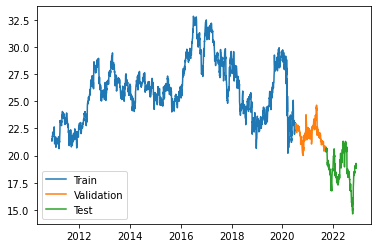

In [14]:
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(1)])

model.compile(loss = 'mse',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['mean_absolute_error'])

model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100)

Epoch 1/100
76/76 [==============================] - 5s 15ms/step - loss: 389.9929 - mean_absolute_error: 17.9128 - val_loss: 27.5197 - val_mean_absolute_error: 5.1716
Epoch 2/100
76/76 [==============================] - 0s 5ms/step - loss: 8.4137 - mean_absolute_error: 2.3452 - val_loss: 18.2919 - val_mean_absolute_error: 4.1890
Epoch 3/100
76/76 [==============================] - 0s 4ms/step - loss: 7.1143 - mean_absolute_error: 2.1440 - val_loss: 16.0347 - val_mean_absolute_error: 3.9179
Epoch 4/100
76/76 [==============================] - 0s 5ms/step - loss: 5.5531 - mean_absolute_error: 1.8834 - val_loss: 10.4036 - val_mean_absolute_error: 3.1531
Epoch 5/100
76/76 [==============================] - 0s 5ms/step - loss: 2.6459 - mean_absolute_error: 1.2611 - val_loss: 2.2425 - val_mean_absolute_error: 1.4461
Epoch 6/100
76/76 [==============================] - 0s 4ms/step - loss: 0.3247 - mean_absolute_error: 0.4033 - val_loss: 0.1549 - val_mean_absolute_error: 0.3070
Epoch 7/100
76

Epoch 51/100
76/76 [==============================] - 0s 4ms/step - loss: 0.1216 - mean_absolute_error: 0.2546 - val_loss: 0.1676 - val_mean_absolute_error: 0.3486
Epoch 52/100
76/76 [==============================] - 0s 5ms/step - loss: 0.1206 - mean_absolute_error: 0.2514 - val_loss: 0.0874 - val_mean_absolute_error: 0.2238
Epoch 53/100
76/76 [==============================] - 0s 5ms/step - loss: 0.1147 - mean_absolute_error: 0.2430 - val_loss: 0.0706 - val_mean_absolute_error: 0.1928
Epoch 54/100
76/76 [==============================] - 0s 4ms/step - loss: 0.1132 - mean_absolute_error: 0.2419 - val_loss: 0.0675 - val_mean_absolute_error: 0.1857
Epoch 55/100
76/76 [==============================] - 0s 4ms/step - loss: 0.1096 - mean_absolute_error: 0.2336 - val_loss: 0.0681 - val_mean_absolute_error: 0.1866
Epoch 56/100
76/76 [==============================] - 0s 5ms/step - loss: 0.1255 - mean_absolute_error: 0.2575 - val_loss: 0.1368 - val_mean_absolute_error: 0.3060
Epoch 57/100
76/

76/76 [==============================] - 1s 2ms/step


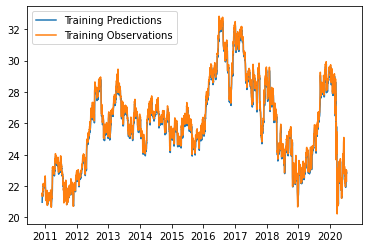

In [16]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

10/10 [==============================] - 0s 3ms/step


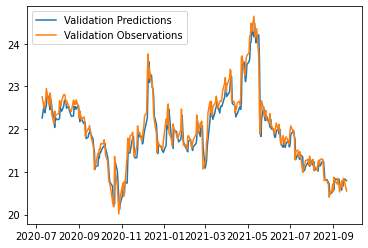

In [17]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

10/10 [==============================] - 0s 3ms/step


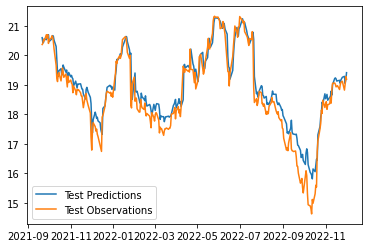

In [18]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])

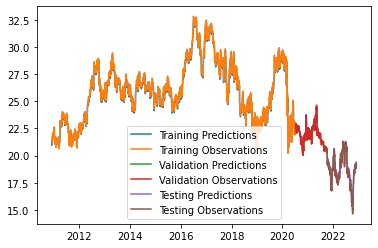

In [19]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [20]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
    last_window = deepcopy(X_train[-1])
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window[-1] = next_prediction

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


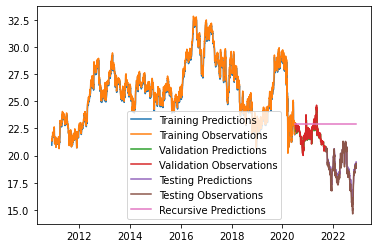

In [21]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])